# Introduction

## To Do

1. Construct a motion primitive library that summarizes the characteristics of arcs
that exist within segments of the solution space.
2. Construct a motion primitive graph that discretely approximates a subset of the
continuous solution space.
3. Search the graph for motion primitive sequences that serve as candidates for initial
guesses for trajectories.
4. Construct an initial guess for each trajectory by refining each motion primitive
sequence.
5. Correct each initial guess to produce a continuous trajectory with impulsive
maneuvers using direct collocation and local optimization.
6. Compute additional transfers spanning segments of the design space.
7. Look into graph search/machine learning methods for stitching together arcs


# Initialization

## Imports

In [5]:
import sys
import os
import random
import math

import numpy as np 
from numpy import cos, sin
import matplotlib
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
import plotly.graph_objects as go

import pickle as pkl
import PIL.Image as Image



from PIL import Image
import copy
import seaborn as sns
from scipy.integrate import odeint
from scipy.integrate import solve_ivp


import gym
from gym import Env, spaces
import time
import operator



from datetime import datetime
import navpy as nav


from poliastro.bodies import Sun, Earth, Moon
from poliastro.ephem import Ephem
from poliastro.frames import Planes
from poliastro.plotting import StaticOrbitPlotter
from poliastro.plotting.misc import plot_solar_system
from poliastro.twobody import Orbit
from poliastro.util import norm, time_range
from poliastro.constants import J2000
from poliastro.plotting import OrbitPlotter3D
from poliastro.plotting import OrbitPlotter2D
from poliastro.twobody.sampling import EpochsArray, TrueAnomalyBounds, EpochBounds
from poliastro.maneuver import Maneuver
from poliastro.twobody.propagation import propagate, cowell
from poliastro import constants



from astropy import units as u
from astropy.time import Time, TimeDelta
from astropy.utils.data import conf
from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body

from astroquery.jplhorizons import Horizons

conf.dataurl
conf.remote_timeout = 10000
solar_system_ephemeris.set("jpl")

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable
from torch.distributions import Normal
from torch.autograd import gradcheck
import torch.nn.init as init
from torch.nn.utils import clip_grad_norm_, clip_grad_value_

from captum.attr import LayerIntegratedGradients
from captum.attr import Saliency
from torchviz import make_dot


from IPython.display import clear_output
import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from math import sqrt

# Circular Restricted Three Body Problem (CR3BP)

In [8]:
M_earth = 5.972e24
M_moon = 7.342e22

u = M_moon/(M_earth+M_moon)


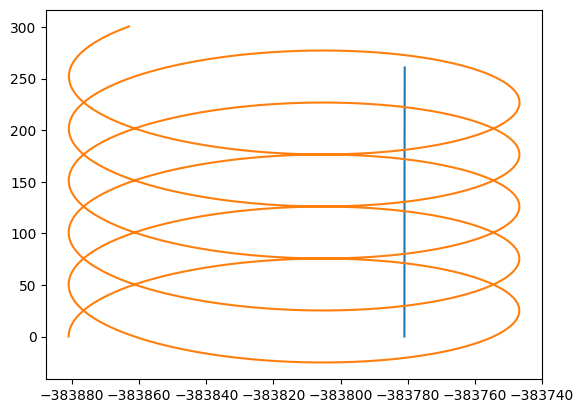

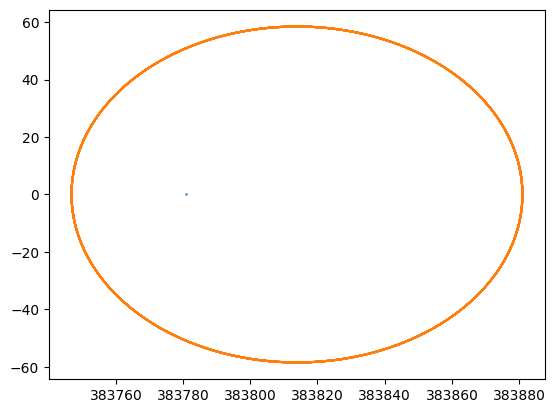

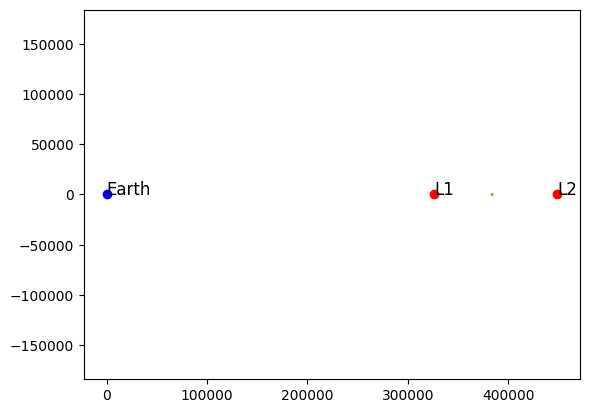

In [10]:


def lunar_Orbit_DEQ(t, x):
    mu_earth = 398600.4
    mu_moon = 4902.8
    
    #Extract the position components from the state vector
    X_m = x[0]
    Y_m = x[1]
    Z_m = x[2]
    
    X_s = x[3]
    Y_s = x[4]
    Z_s = x[5]
    
    r_m = np.array([X_m, Y_m, Z_m])
    rm = np.linalg.norm(r_m)

    r_s = np.array([X_s, Y_s, Z_s])
    rs = np.linalg.norm(r_s)
    
    r_m_s = r_m - r_s
    rms = np.linalg.norm(r_m_s)
    #Extract the velocities from the state vector
    vX_m = x[6]
    vY_m = x[7]
    vZ_m = x[8]
    
    vX_s = x[9]
    vY_s = x[10]
    vZ_s = x[11]
    
    a_earth_m = -mu_earth*r_m/rm**3
    a_earth_s = -mu_earth*r_s/rs**3

    a_moon_s = mu_moon*((r_m_s/rms**3) - (r_m/rm**3))
    
    a_m = a_earth_m
    a_s = a_earth_s + a_moon_s
    
    dxdt = [vX_m, vY_m, vZ_m, vX_s, vY_s, vZ_s, a_m[0], a_m[1], a_m[2], a_s[0], a_s[1], a_s[2]]
    
    return dxdt

def ECI_2_MFR_DCM(r_m, v_m, r_s):
    r_m_q = []
    r_s_q = []
    Q_ = []
    
    for n in range(0, r_m.shape[1]):
        x = r_m[:, n]
        z = np.cross(x, v_m[:, n])
        y = np.cross(z, x)

        i_ = x/np.linalg.norm(x)
        j_ = y/np.linalg.norm(y)
        k_ = z/np.linalg.norm(z)

        Q = [i_.T, j_.T, k_.T]

        Q_.append(Q)
        r_m_q.append(Q@r_m[:,n])
        r_s_q.append(Q@r_s[:,n])

    r_m_q = np.array(r_m_q)
    r_s_q = np.array(r_s_q)
    Q_ = np.array(Q_)        
        
    return Q_, r_m_q, r_s_q

t_span = (0, 2551520/10000)
t = np.linspace(t_span[0], t_span[1], num=100000)

x_0_m = np.array([-383781, 0, 0, 0, 1.022, 0])
x_0_s = x_0_m + np.array([-100, 0, 0, 0, .656, 0])
x_0_s = x_0_m + np.array([-100, 0, 0, 0, 5, 0])


x_0 = np.concatenate((x_0_m[:3],x_0_s[:3], x_0_m[3:], x_0_s[3:]))



# y = odeint(lunar_DEQ, x_0,t)
sol = solve_ivp(lunar_Orbit_DEQ, t_span, x_0,t_eval=t, dense_output='True', rtol=1e-11, atol=1e-11 )


#Extract Lunar position components
x_m = sol.y[0,:]
y_m = sol.y[1,:]
#Extract Lunar position vector
v_m = sol.y[6:9,:]
r_m = sol.y[0:3,:]
#Extract Satellite position components
x_s = sol.y[3,:]
y_s = sol.y[4,:]
#Extract Satellite position Vector
r_s = sol.y[3:6,:]

plt.plot(x_m, y_m)
plt.plot(x_s, y_s)
plt.show()

#Perform frame change to moon-fixed rotating frame
Q, r_m, r_s =ECI_2_MFR_DCM(r_m, v_m, r_s)

#Extract position components for plotting
x_m = r_m[:, 0]
y_m = r_m[:, 1]

x_s = r_s[:, 0]
y_s = r_s[:, 1]

plt.plot(x_m, y_m)
plt.plot(x_s, y_s)
plt.show()


x_points = [0, 326390, 448900]
y_points = [0, 0, 0]

labels = ['Earth', 'L1', 'L2']
plt.scatter(x_points[0], y_points[0], color='Blue')
plt.scatter(x_points[1:], y_points[1:], color='Red')
for label, x_val, y_val in zip(labels, x_points, y_points):
    plt.text(x_val, y_val, label, fontsize=12, ha='left')

plt.plot(x_m, y_m)
plt.plot(x_s, y_s)
plt.axis('equal')
plt.show()

In [19]:
u = M_moon/(M_earth+M_moon)

def Jacobi_Const(u,s):
    #This function computes the jacobi constant for
    #a given body in the rotating fixed frame of the CR3BP 
    #u: the mass ratio of the two primary bodies, M2/(M1+M2)
    #s: the object state, a list or ndarray structured as: [x, y, z, dx, dy, dz]
    #NOTE: s must be given in non-dimensional units for this formula to be valid
    
    #Extract state variables
    x = s[0]
    y = s[1]
    z = s[2]

    dx = s[3]
    dy = s[4]
    dz = s[5]

    #Compute the relative position magnitudes
    r1 = np.sqrt((x+u)**2 + y**2 + z**2)
    r2 = np.sqrt((x-1+u)**2 + y**2 + z**2)
    
    #Compute the jacobi constant
    CJ = (x**2 + y**2) + (2*(1-u)/r1) + (2*u/r2) - dx**2 - dy**2 - dz**2
    
    return CJ

s = sol.y[[3, 4, 5, 9, 10, 11],:]

CJ = Jacobi_Const(u,s)

print(CJ)

[1.47364622e+11 1.47364622e+11 1.47364622e+11 ... 1.47350923e+11
 1.47350915e+11 1.47350907e+11]


In [6]:
sqrt(2)

1.4142135623730951

In [ ]:
# Step 1: Construct initial guess
initial_guess = construct_initial_guess()

# Step 2: Discretize into multiple arcs
arcs = discretize(initial_guess)

# Step 3: Set states at the beginning of all arcs as free variables
free_variables = get_initial_states(arcs)

# Step 4: Iteratively adjust free variables for continuity
while not converged:
    # Compute state trajectory for each arc
    for arc in arcs:
        trajectory = integrate(arc, free_variables)
        
        # Adjust free variables using Newton's method
        free_variables = adjust_variables(arc, free_variables, trajectory)
    
    # Check for convergence
    if within_tolerance(free_variables):
        break

# Step 5: Use pseudo-arclength continuation
while not termination_criteria_met():
    # Compute additional members along the periodic orbit family
    additional_member = pseudo_arclength_continuation(arcs, free_variables)
    
    if termination_criteria_met():
        break

# Final Result: Obtained periodic orbit
final_periodic_orbit = concatenate_arcs(arcs)

In [137]:
#Use Curtis book to formulate motion in earth-moon co-rotating frame

#non-dimensionalize plots/data
#Plot trajectories
#Vary initial conditions, try to match variance wth paper
#Perform stability analysis


## Construct Motion Primitive Library

## Construct Motion Primitive Graph

## Identify Candidate Motion Primitive Sequences

## Construct an Initial Guess from a Primitive Sequence

## Recover a Continuous Trajectory

## Explore the Transfer Design Space